# Module

In [1]:
import gc
import optuna
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Dataset

In [2]:
train = pd.read_csv('../input/titanic/train.csv')

print(train.shape)
train.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


・PassengerId：乗客ID<br>
・Survived：生存したかどうか（0：助からない、1：助かる）<br>
・Pclass – チケットのクラス（1：上層クラス、2：中級クラス、3：下層クラス）<br>
・Name：乗客の名前<br>
・Sex：性別<br>
・Age：年齢<br>
・SibSp：船に同乗している兄弟・配偶者の数<br>
・Parch：船に同乗している親・子供の数<br>
・Ticket：チケット番号<br>
・Fare：料金<br>
・Cabin：客室番号<br>
・Embarked：船に乗った港（C：Cherbourg、Q：Queenstown、S：Southampton）<br>

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
test = pd.read_csv('../input/titanic/test.csv')

print(test.shape)
test.head()

(418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
submission = pd.read_csv('../input/titanic/gender_submission.csv')
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


# Visualization

In [6]:
sns.set()

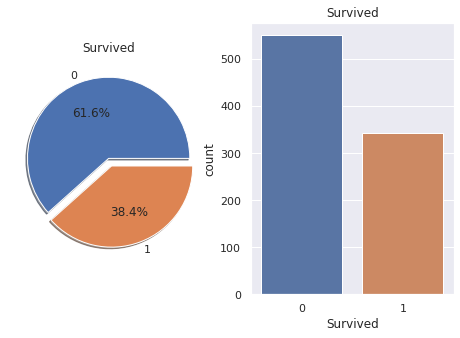

In [7]:
figure ,ax = plt.subplots(1,2,figsize=(8,5))

train['Survived'].value_counts().plot.pie(explode=[0,0.1], autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title('Survived')
ax[0].set_ylabel('')

sns.countplot(x='Survived', data=train, ax=ax[1])
ax[1].set_title('Survived')

plt.show()

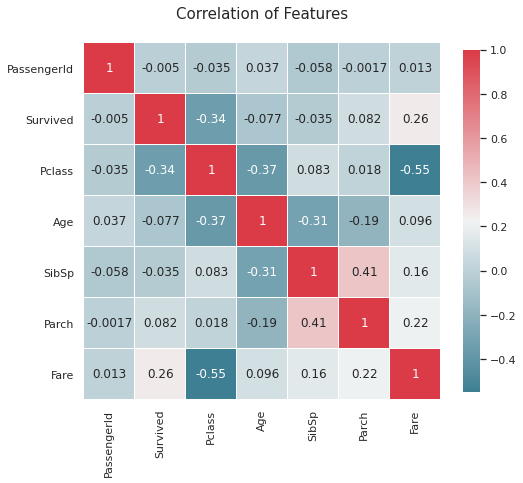

In [8]:
def correlation_heatmap(df):
    fig, ax = plt.subplots(figsize =(8, 7))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    fig = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Correlation of Features', y=1.05, size=15)

correlation_heatmap(train)

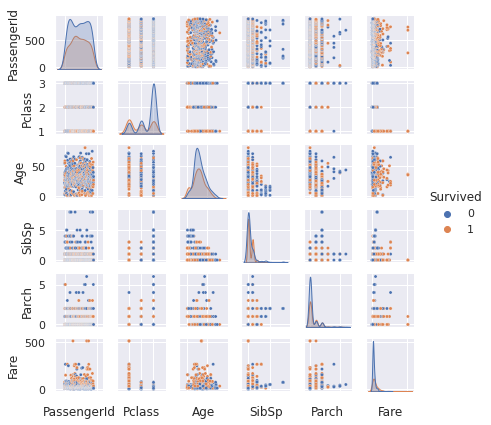

In [9]:
pp = sns.pairplot(train, hue = 'Survived', palette = 'deep', height=1, aspect=1, diag_kind = 'kde', diag_kws=dict(shade=True), plot_kws=dict(s=10))
pp.set(xticklabels=[])

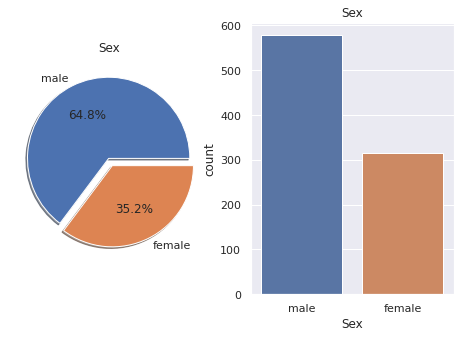

In [10]:
figure ,ax = plt.subplots(1,2,figsize=(8,5))

train['Sex'].value_counts().plot.pie(explode=[0,0.1], autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title('Sex')
ax[0].set_ylabel('')

sns.countplot(x='Sex', data=train, ax=ax[1])
ax[1].set_title('Sex')

plt.show()

<AxesSubplot:xlabel='Sex', ylabel='count'>

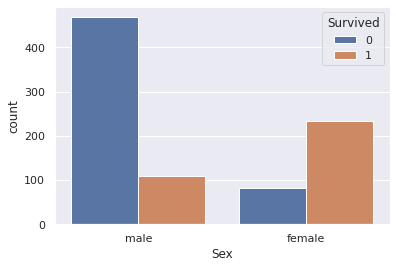

In [11]:
sns.countplot(x='Sex', data=train, hue='Survived')

<AxesSubplot:xlabel='Age_rank', ylabel='count'>

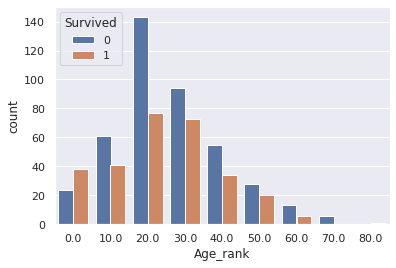

In [12]:
train['Age_rank'] = pd.Categorical(np.floor(train['Age']/10)*10)

sns.countplot(x='Age_rank', data=train, hue='Survived')

<AxesSubplot:xlabel='Pclass', ylabel='count'>

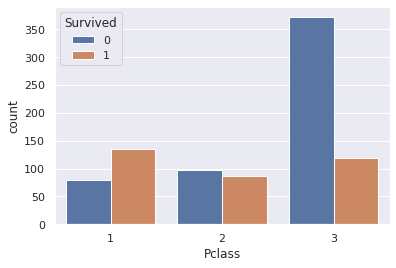

In [13]:
sns.countplot(x='Pclass', data=train, hue='Survived')

<AxesSubplot:xlabel='SibSp', ylabel='count'>

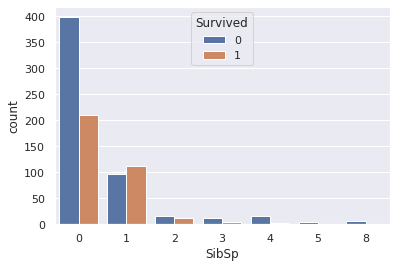

In [14]:
sns.countplot(x='SibSp', data=train, hue='Survived')

<AxesSubplot:xlabel='Parch', ylabel='count'>

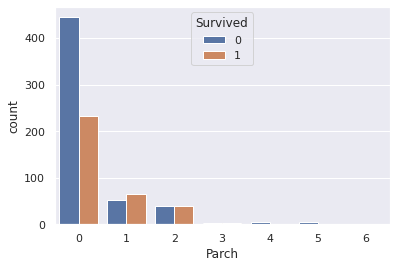

In [15]:
sns.countplot(x='Parch', data=train, hue='Survived')

<AxesSubplot:xlabel='Embarked', ylabel='count'>

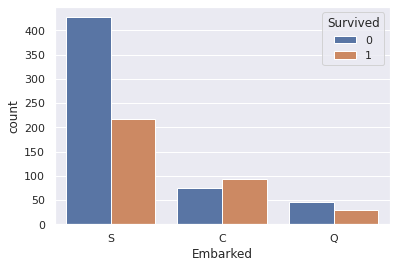

In [16]:
sns.countplot(x='Embarked', data=train, hue='Survived')

# Feature Engineering

<AxesSubplot:xlabel='Pclass_high', ylabel='count'>

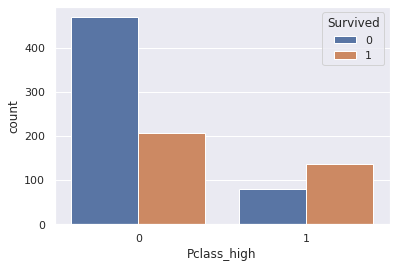

In [17]:
train['Pclass_high'] = 0
train.loc[train['Pclass'] == 1, 'Pclass_high'] = 1

sns.countplot(x='Pclass_high', data=train, hue='Survived')

<AxesSubplot:xlabel='Family_size', ylabel='count'>

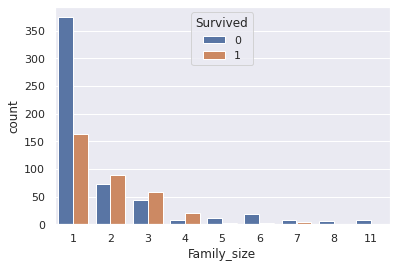

In [18]:
train['Family_size'] = train['SibSp'] + train['Parch'] + 1

sns.countplot(x='Family_size', data=train, hue='Survived')

<AxesSubplot:xlabel='Embarked_C', ylabel='count'>

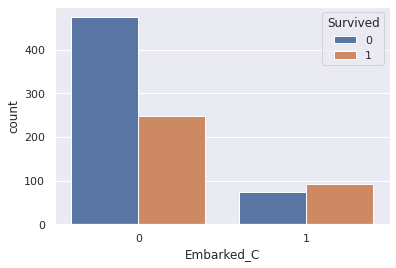

In [19]:
def Embarked_C_transform(x):
    if x == 'C':
        y = 1
    else:
        y = 0
    return y

train['Embarked_C'] = train['Embarked'].apply(lambda x: Embarked_C_transform(x))

sns.countplot(x='Embarked_C', data=train, hue='Survived')

# Preprocess

In [20]:
def Sex_transform(x):
    if x == 'male':
        y = 0
    else:
        y = 1
    return y

train['Sex'] = train['Sex'].apply(lambda x: Sex_transform(x))

In [21]:
def Embarked_transform(x):
    if x == 'C':
        y = 0
    elif x == 'Q':
        y = 1
    else:
        y = 2

    return y

train['Embarked'] = train['Embarked'].apply(lambda x: Embarked_transform(x))

In [22]:
features = [
    'Pclass',
    'Sex',
    'Age',
    'SibSp',
    'Parch',
    'Fare',
    'Embarked',
    'Pclass_high',
    'Family_size',
    'Embarked_C'
]

target = 'Survived'

In [23]:
X_train = train[features].fillna(-999)
y_train = train[target]

X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Pclass       891 non-null    int64  
 1   Sex          891 non-null    int64  
 2   Age          891 non-null    float64
 3   SibSp        891 non-null    int64  
 4   Parch        891 non-null    int64  
 5   Fare         891 non-null    float64
 6   Embarked     891 non-null    int64  
 7   Pclass_high  891 non-null    int64  
 8   Family_size  891 non-null    int64  
 9   Embarked_C   891 non-null    int64  
dtypes: float64(2), int64(8)
memory usage: 69.7 KB


In [24]:
del(train)
gc.collect()

4617

# Modeling

In [25]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=666)

print(X_tr.shape)
print(y_val.shape)
print(X_tr.shape)
print(y_val.shape)

(712, 10)
(179,)
(712, 10)
(179,)


In [26]:
'''
def create_model(trial):
    num_leaves = trial.suggest_int('num_leaves', 2, 31)
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 0.99)
    max_depth = trial.suggest_int('max_depth', 3, 8)
    min_child_samples = trial.suggest_int('min_child_samples', 100, 1200)
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 5, 90)
    bagging_freq = trial.suggest_int('bagging_freq', 1, 7)
    bagging_fraction = trial.suggest_uniform('bagging_fraction', 0.0001, 1.0)
    feature_fraction = trial.suggest_uniform('feature_fraction', 0.0001, 1.0)
    subsample = trial.suggest_uniform('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 1.0)
    
    model = lgb.LGBMClassifier(
        num_leaves=num_leaves,
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth, 
        min_child_samples=min_child_samples, 
        min_data_in_leaf=min_data_in_leaf,
        bagging_freq=bagging_freq,
        bagging_fraction=bagging_fraction,
        feature_fraction=feature_fraction,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        random_state=666)
        
    return model

def objective(trial):
    model = create_model(trial)
    model.fit(X_tr, y_tr)
    y_proba = model.predict_proba(X_val)[:,1]
    score = roc_auc_score(y_val, y_proba)
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=40)
params = study.best_params

print(params)

'''

"\ndef create_model(trial):\n    num_leaves = trial.suggest_int('num_leaves', 2, 31)\n    n_estimators = trial.suggest_int('n_estimators', 50, 300)\n    learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 0.99)\n    max_depth = trial.suggest_int('max_depth', 3, 8)\n    min_child_samples = trial.suggest_int('min_child_samples', 100, 1200)\n    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 5, 90)\n    bagging_freq = trial.suggest_int('bagging_freq', 1, 7)\n    bagging_fraction = trial.suggest_uniform('bagging_fraction', 0.0001, 1.0)\n    feature_fraction = trial.suggest_uniform('feature_fraction', 0.0001, 1.0)\n    subsample = trial.suggest_uniform('subsample', 0.1, 1.0)\n    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 1.0)\n    \n    model = lgb.LGBMClassifier(\n        num_leaves=num_leaves,\n        n_estimators=n_estimators,\n        learning_rate=learning_rate,\n        max_depth=max_depth, \n        min_child_samples=min_child_samples, \n

In [27]:
params = {'num_leaves': 2,
          'n_estimators': 130,
          'learning_rate': 0.5296027742301195,
          'max_depth': 5,
          'min_child_samples': 813,
          'min_data_in_leaf': 18,
          'bagging_freq': 6,
          'bagging_fraction': 0.8054340854017729,
          'feature_fraction': 0.9420584896659971,
          'subsample': 0.20243845857908754, 
          'colsample_bytree': 0.6437211091498366,
          'random_state': 666}

In [28]:
%%time

cls = lgb.LGBMClassifier(**params)
cls.fit(X_train, y_train)

y_proba = cls.predict_proba(X_val)[:,1]

print('AUC: ', roc_auc_score(y_val, y_proba))

[LightGBM] [Warning] bagging_fraction is set=0.8054340854017729, subsample=0.20243845857908754 will be ignored. Current value: bagging_fraction=0.8054340854017729
[LightGBM] [Warning] feature_fraction is set=0.9420584896659971, colsample_bytree=0.6437211091498366 will be ignored. Current value: feature_fraction=0.9420584896659971
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=813 will be ignored. Current value: min_data_in_leaf=18
AUC:  0.8969855832241154
CPU times: user 425 ms, sys: 3.14 ms, total: 429 ms
Wall time: 160 ms


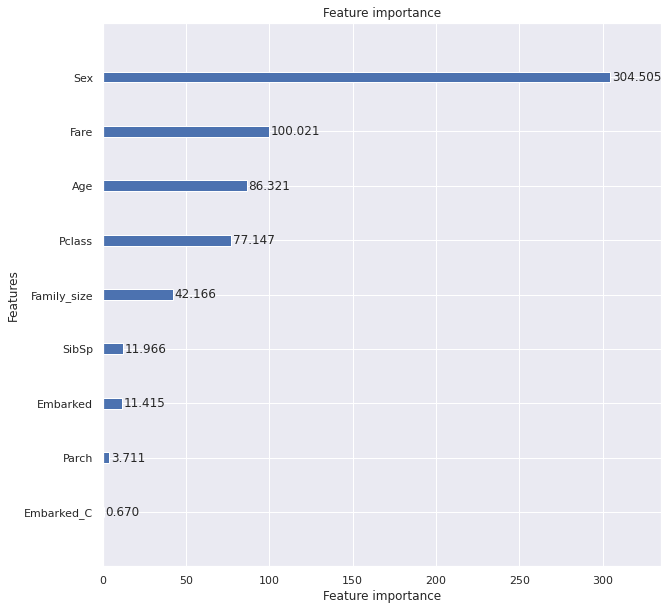

In [29]:
fig,ax = plt.subplots(figsize=(10,10))
lgb.plot_importance(cls, ax=ax,importance_type='gain',max_num_features=9)
plt.show()

# Submit

In [30]:
test['Pclass_high'] = 0
test.loc[test['Pclass'] == 1, 'Pclass_high'] = 1
test['Family_size'] = test['SibSp'] + test['Parch'] + 1
test['Sex'] = test['Sex'].apply(lambda x: Sex_transform(x))
test['Embarked'] = test['Embarked'].apply(lambda x: Embarked_transform(x))
test['Embarked_C'] = test['Embarked'].apply(lambda x: Embarked_C_transform(x))

print(test.shape)
test.head()

(418, 14)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Pclass_high,Family_size,Embarked_C
0,892,3,"Kelly, Mr. James",0,34.5,0,0,330911,7.8292,NaN,1,0,1,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",1,47.0,1,0,363272,7.0000,NaN,2,0,2,0
2,894,2,"Myles, Mr. Thomas Francis",0,62.0,0,0,240276,9.6875,NaN,1,0,1,0
3,895,3,"Wirz, Mr. Albert",0,27.0,0,0,315154,8.6625,NaN,2,0,1,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,22.0,1,1,3101298,12.2875,NaN,2,0,3,0


In [31]:
X_test = test[features].fillna(-999)

X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Pclass       418 non-null    int64  
 1   Sex          418 non-null    int64  
 2   Age          418 non-null    float64
 3   SibSp        418 non-null    int64  
 4   Parch        418 non-null    int64  
 5   Fare         418 non-null    float64
 6   Embarked     418 non-null    int64  
 7   Pclass_high  418 non-null    int64  
 8   Family_size  418 non-null    int64  
 9   Embarked_C   418 non-null    int64  
dtypes: float64(2), int64(8)
memory usage: 32.8 KB


In [32]:
y_pred = cls.predict(X_test)
print(y_pred[:10])

[0 0 0 0 1 0 1 0 1 0]


In [33]:
submit = pd.DataFrame(y_pred, index=test['PassengerId'], columns=['Survived'])
submit.head(10)

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,1
897,0
898,1
899,0
900,1


In [34]:
submit.to_csv('titanic_submit.csv')